In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

width, height = 1333, 2000

# Getting colors from image

In [2]:
# Load image
image = Image.open('Images/05-lemlem-resort-18.jpg')
                   
# Resize image
image = image.resize((width, height))

# Number of different colors in the original image
colors = image.getcolors(width*height)
len(colors)

117763

Too many different colors. If We take the top 5 colors, then all of them are the same, just slightly different shades. To capture more essential colors:
* Reduce the number of colors in an image
* Exclude background color
* Exclude skin, hair color
Cropping image is another method, but may get inaccurate result (there are pictures of 2 models)

### Reduce the number of colors

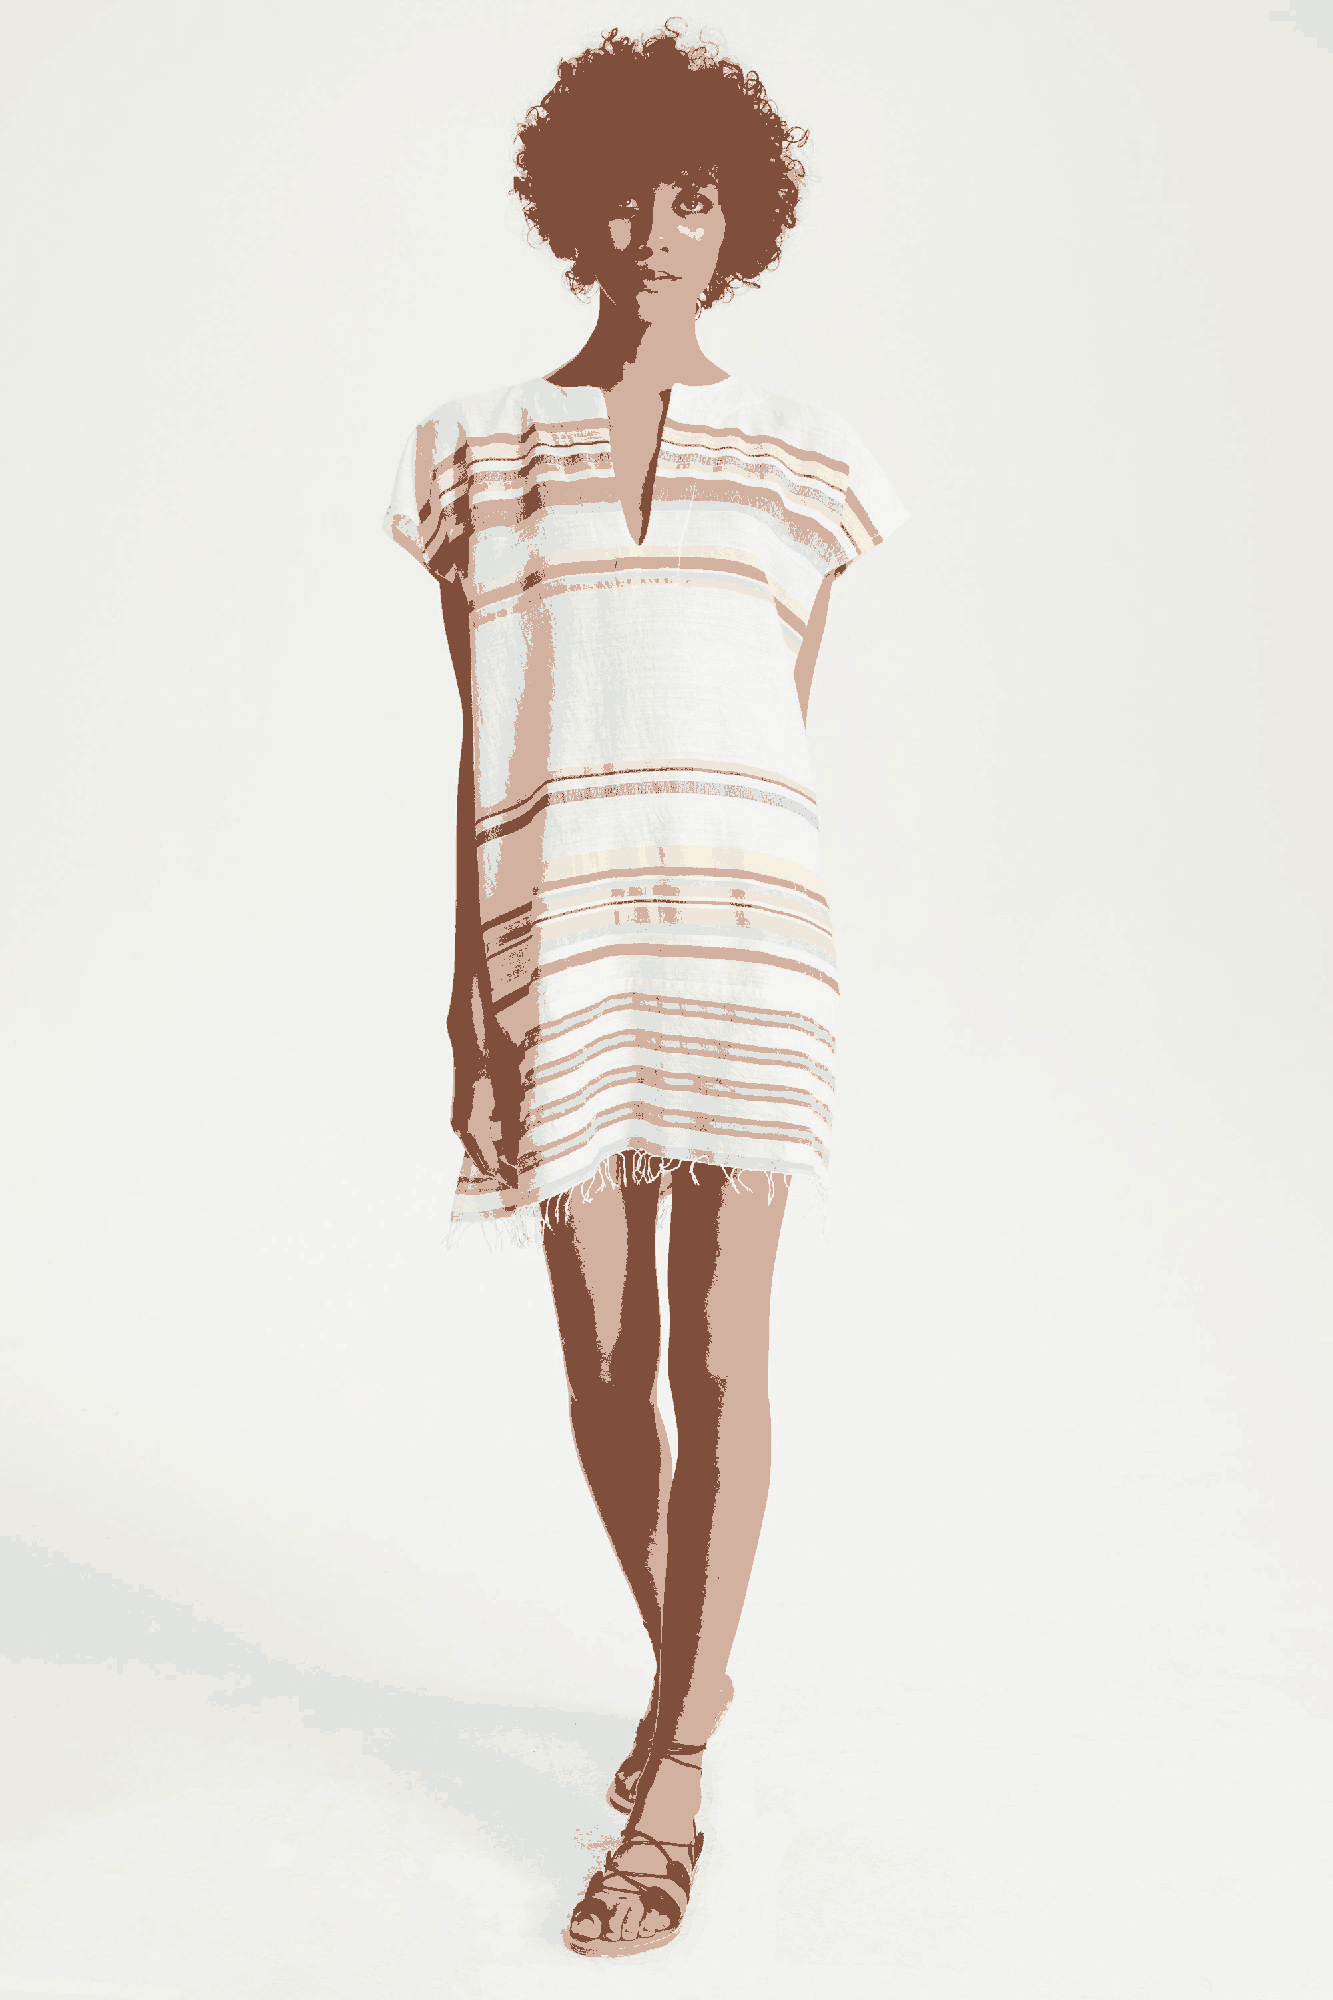

In [3]:
# Reduce the number of colors
result = image.convert('P', palette=Image.ADAPTIVE, colors=20)
result

In [4]:
# Add an alpha column to the colors
result.putalpha(0)

# Get colors
colors = result.getcolors(width*height)

In [5]:
colors

[(139563, (128, 79, 60, 0)),
 (8261, (242, 242, 246, 0)),
 (34347, (245, 245, 241, 0)),
 (22237, (245, 243, 241, 0)),
 (529847, (242, 242, 240, 0)),
 (88881, (241, 239, 238, 0)),
 (232597, (241, 241, 237, 0)),
 (86822, (239, 239, 237, 0)),
 (171261, (240, 241, 235, 0)),
 (99561, (240, 239, 235, 0)),
 (191220, (239, 240, 234, 0)),
 (356452, (238, 238, 233, 0)),
 (196143, (236, 237, 231, 0)),
 (6251, (233, 236, 231, 0)),
 (195576, (235, 234, 229, 0)),
 (673, (238, 242, 228, 0)),
 (8513, (247, 239, 224, 0)),
 (116279, (225, 227, 224, 0)),
 (151973, (211, 177, 160, 0)),
 (29543, (238, 229, 219, 0))]

This can make the analysis simpler, but likely to lose important colors.

# Helping Functions

In [6]:
# Get all colors of an image
def get_colors(filename, width=1333, height=2000):
    image = Image.open(filename)
    image = image.resize((width, height))
    colors = image.getcolors(width*height)
    return colors

In [7]:
# Build dataset of colors
def build_dataset(colors):
    rgb = []
    for count, col in colors:
        rgb.append(list(col))

    # Create data frame from rgb list
    rgb = pd.DataFrame(rgb, columns=['R', 'G', 'B'])
    return rgb

In [8]:
# Visualize the colors
def draw_palette(data, numcolors=20, block_size=20):
    pal = Image.new('RGB', (block_size*numcolors, block_size))
    draw = ImageDraw.Draw(pal)

    posx = 0
    for count, col in sorted(data, key=lambda x: x[0], reverse=True)[:numcolors]:
        draw.rectangle([posx, 0, posx+block_size, block_size], fill=col)
        posx = posx + block_size

    plt.figure(figsize=(20, 20))
    plt.imshow(pal)

# 1. Reduce Colors
This method requires to add alpha. So the dataset is built differently from other methods

In [9]:
# Build data
def build_data1(folder, numcolors=5):
    data = []
    for filename in os.listdir(folder):
        image = Image.open(folder + '/' + filename)
        image = image.resize((width, height))

        # Reduce color
        result = image.convert('P', palette=Image.ADAPTIVE, colors=numcolors)

        # Add an alpha column to the colors
        result.putalpha(0)

        # Get colors
        colors = result.getcolors(width*height)

        # Merge to data
        data.extend(colors)
        
    # Return sorted data
    return sorted(data, key=lambda x:x[0], reverse=True)

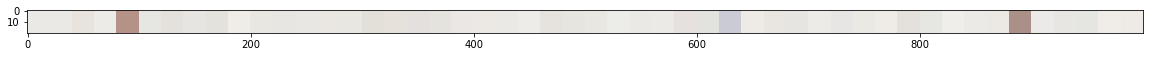

In [10]:
data1 = build_data1('2017')
draw_palette(data1, numcolors=50)
# plt.savefig('2017-basic.png')

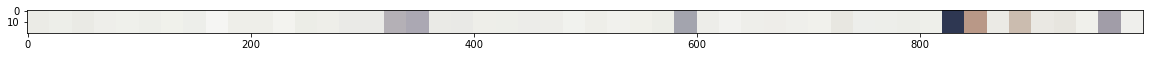

In [11]:
data2 = build_data1('2018')
draw_palette(data2, numcolors=50)
# plt.savefig('2018-basic.png')

This captures a few blue color trend changes of 2017 and 2018. Since colors are grouped early using PIL's algorithm, we likely to lose small small accent colors. Background colors appear a lot in between clothes colors

# 2. Kmeans (fixed number of clusters)

In this approach, we use kmeans to group the colors to separate the background, skin, hair colors from the clothe's colors. The number of clusters is fixed for all images.

In [12]:
# Build data
def build_data2(folder):
    data = []
    for filename in os.listdir(folder):
        image = Image.open(folder + '/' + filename)
        image = image.resize((width, height))

        # Get colors
        colors = image.getcolors(width*height)

        # Ignore the count, only the colors
        for item in colors:
            data.append(list(item[1]))

    return data

### Apply to 2017 data

In [13]:
data3 = build_data2('2017')

In [14]:
# Fit KMeans
km2017 = KMeans()
km2017.fit(data3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
# View clusters
print np.unique(km2017.labels_)
centers2017 = km2017.cluster_centers_
centers2017

[0 1 2 3 4 5 6 7]


array([[ 193.39957784,  133.56347923,  109.19182659],
       [ 234.30066991,  216.77198828,  213.21697407],
       [ 118.42106187,  131.76517366,  156.27664787],
       [  61.14318682,   40.92167024,   34.35103207],
       [ 179.49250896,  177.56342632,  185.89091897],
       [ 234.80112394,   48.04241276,  133.91855426],
       [ 130.17366076,   91.17848688,   74.97961152],
       [ 232.8584886 ,  168.01324942,  152.82789583]])

In [16]:
# Visualize the 8 cluster centers
def draw_palette_new(data, block_size=20):
    pal = Image.new('RGB', (block_size*len(data), block_size))
    draw = ImageDraw.Draw(pal)

    posx = 0
    for col in data:
        col = tuple([int(i) for i in col])
        print col
        draw.rectangle([posx, 0, posx+block_size, block_size], fill=col)
        posx = posx + block_size

    plt.figure(figsize=(20, 20))
    plt.imshow(pal)

(193, 133, 109)
(234, 216, 213)
(118, 131, 156)
(61, 40, 34)
(179, 177, 185)
(234, 48, 133)
(130, 91, 74)
(232, 168, 152)


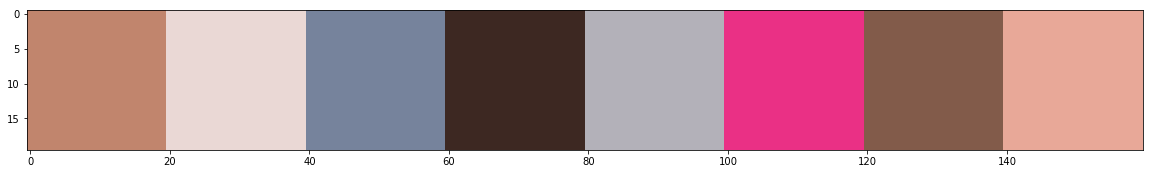

In [17]:
draw_palette_new(centers2017)
# plt.savefig('2017-kmeans.png')

Finally we can capture the pink color of the collection.

### Apply to 2018 data

In [18]:
data4 = build_data2('2018')

In [19]:
# Fit KMeans
km2018 = KMeans()
km2018.fit(data4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
# View clusters
print np.unique(km2018.labels_)
centers2018 = km2018.cluster_centers_
centers2018

[0 1 2 3 4 5 6 7]


array([[ 211.92310657,  175.80134408,  152.96254991],
       [  56.92709609,   77.72731174,  116.57265086],
       [ 129.44949428,   82.4381422 ,   60.38467856],
       [ 225.40793976,  222.19672626,  220.95581196],
       [  44.75695574,   33.86128423,   36.20047003],
       [ 184.29889619,  129.84162047,  101.50070695],
       [ 149.60373123,  179.5909742 ,  216.0319101 ],
       [ 101.99469131,  130.56489366,  170.35360127]])

(211, 175, 152)
(56, 77, 116)
(129, 82, 60)
(225, 222, 220)
(44, 33, 36)
(184, 129, 101)
(149, 179, 216)
(101, 130, 170)


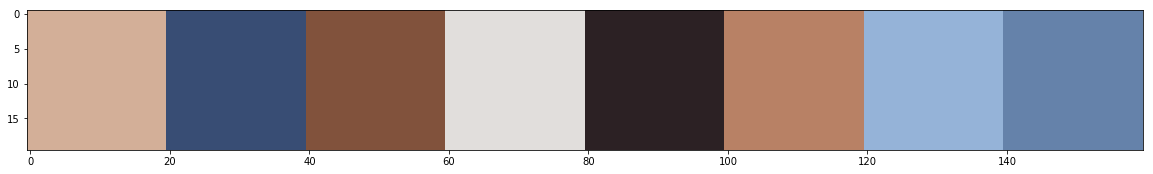

In [21]:
draw_palette_new(centers2018)
# plt.savefig('2018-kmeans.png')

Could also consider the counts and size of clusters to see which colors occur the most.

# Exploratory Data Analysis

In [22]:
import seaborn as sb

# Build the full dataset of 2017
def build_data(folder):
    data = []
    for filename in os.listdir(folder):
        image = Image.open(folder + '/' + filename)
        image = image.resize((width, height))

        # Get colors
        colors = image.getcolors(width*height)

        # Merge to data
        
        for item in colors:
            temp = []
            temp.append(item[0])
            for i in item[1]:
                temp.append(i)
        
            data.append(temp)
        
    # Return sorted data
    return data

In [23]:
# # Original data size
# print len(data_full)

# # Combine data by color
# df = pd.DataFrame(data_full, columns=['count', 'color']).groupby('color').agg('sum')
# data_full = zip(df.index, *df.values.T)

# # Data size after combining
# print len(data_full)

In [24]:
data_2017 = np.array(build_data('2017'))
data_2018 = np.array(build_data('2018'))

### Is the trend from 2017 to 2018 getting darker or lighter?

In [25]:
length_2017 = np.sum(data_2017[:, 0])
length_2018 = np.sum(data_2018[:, 0])

# Calculate the average for RGB in 2017
red_2017 = np.sum(data_2017[:, 0] * data_2017[:, 1]) / length_2017
green_2017 = np.sum(data_2017[:, 0] * data_2017[:, 2]) / length_2017
blue_2017 = np.sum(data_2017[:, 0] * data_2017[:, 3])/ length_2017

In [26]:
# Calculate the total for RGB in 2018
red_2018 = np.sum(data_2018[:, 0] * data_2018[:, 1]) / length_2018
green_2018 = np.sum(data_2018[:, 0] * data_2018[:, 2]) / length_2018
blue_2018 = np.sum(data_2018[:, 0] * data_2018[:, 3]) / length_2018

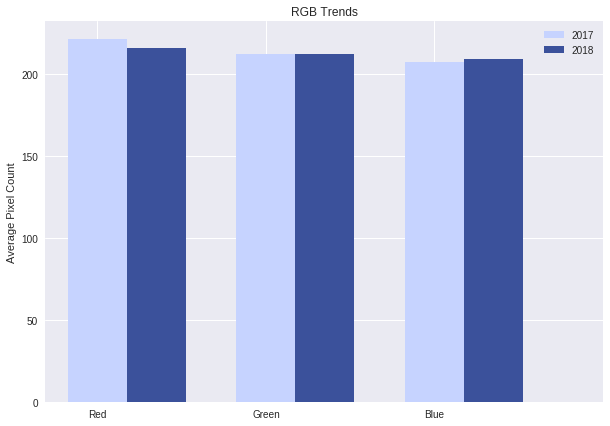

In [27]:
# Bar plot (RGB)
N = 3
rgb2017 = (red_2017, green_2017, blue_2017)
rgb2018 = (red_2018, green_2018, blue_2018)


ind = np.arange(N)  # the x locations for the groups
width = 0.35    # the width of the bars

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, rgb2017, width, color='#c6d3ff')
rects2 = ax.bar(ind+width, rgb2018, width, color='#3b519b')

# add labels
ax.set_ylabel('Average Pixel Count')
ax.set_title('RGB Trends')
ax.set_xticklabels( ('Red', 'Green', 'Blue') )
ax.legend( (rects1[0], rects2[0]), ('2017', '2018'))
plt.xticks(np.arange(4))

plt.savefig('RG_trend.png')

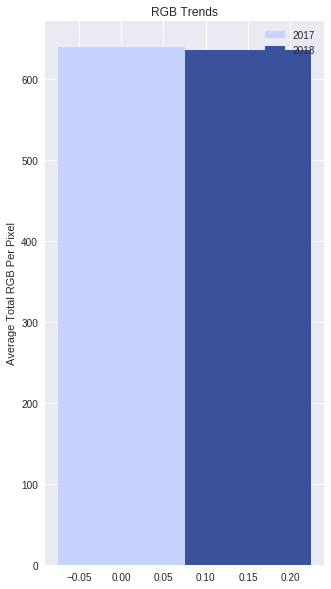

In [28]:
# Bar plot (total)
N = 1
rgb2017 = (red_2017+green_2017+blue_2017)
rgb2018 = (red_2018+green_2018+blue_2018)


ind = np.arange(N)  # the x locations for the groups
width = 0.15    # the width of the bars

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, rgb2017, width, color='#c6d3ff')
rects2 = ax.bar(ind+width, rgb2018, width, color='#3b519b')

# add labels
ax.set_ylabel('Average Total RGB Per Pixel')
ax.set_title('RGB Trends')
ax.legend( (rects1[0], rects2[0]), ('2017', '2018'))

# plt.savefig('total_trend.png')

The total doesn't reflect how light/dark the colors are. We can further count the percentage of pixels that have total RGB over half (384)

### Percentage of dark/light pixels

In [29]:
# Get list of  from 2017
def get_total_colors(data):
    colors = data[:,1] + data[:,2] + data[:,3]
    counts = data[:, 0]

    # Repeat counts to generate the 2017 dataset
    total = []
    for i in range(len(counts)):
        total.extend(list(itertools.repeat(colors[i], counts[i])))
    return total

In [30]:
# Get lists of 2017 and 2018
p2017 = get_total_colors(data_2017)
p2018 = get_total_colors(data_2018)

In [31]:
# Get percentage of pixels having total RGB > 384 and < 384 (2017)
percent_light_2017 = len([num for num in p2017 if num >= 384]) / float(length_2017)
percent_dark_2017 = len([num for num in p2017 if num < 384]) / float(length_2017)

In [32]:
percent_light_2017, percent_dark_2017

(0.9554547824456114, 0.044545217554388596)

In [33]:
# Get percentage of pixels having total RGB > 384 and < 384 (2018)
percent_light_2018 = len([num for num in p2018 if num >= 384]) / float(length_2018)
percent_dark_2018 = len([num for num in p2018 if num < 384]) / float(length_2018)

In [34]:
percent_light_2018, percent_dark_2018

(0.9120224274818705, 0.08797757251812953)

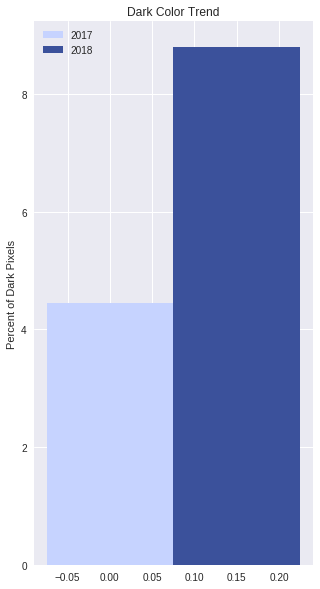

In [35]:
# Bar plot (dark)
N = 1

data1 = percent_dark_2017 * 100
data2 = percent_dark_2018 * 100

ind = np.arange(N)  # the x locations for the groups
width = 0.15    # the width of the bars

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, data1, width, color='#c6d3ff')
rects2 = ax.bar(ind+width, data2, width, color='#3b519b')

# add labels
ax.set_ylabel('Percent of Dark Pixels')
ax.set_title('Dark Color Trend')
ax.legend( (rects1[0], rects2[0]), ('2017', '2018'))

# plt.savefig('percent_dark.png')

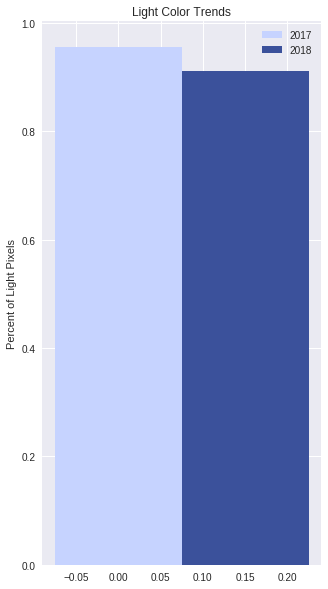

In [36]:
# Bar plot (light)
N = 1

data1 = percent_light_2017
data2 = percent_light_2018

ind = np.arange(N)  # the x locations for the groups
width = 0.15    # the width of the bars

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, data1, width, color='#c6d3ff')
rects2 = ax.bar(ind+width, data2, width, color='#3b519b')

# add labels
ax.set_ylabel('Percent of Light Pixels')
ax.set_title('Light Color Trends')
ax.legend( (rects1[0], rects2[0]), ('2017', '2018'))

# plt.savefig('percent_light.png')

# Other Ideas (background removal)

### Edge Detection

In [37]:
# Using filter
# edge = image.filter(ImageFilter.FIND_EDGES)
# plt.imshow(edge)

### Masking Background

In [38]:
# mask=image.convert("L")
# th=200 # the value has to be adjusted for an image of interest 
# mask = mask.point(lambda i: i < th and 255)
# mask

In [39]:
# threshold=
# dist=200
# img=Image.open('Images/23-lemlem-resort-18.jpg').convert('RGBA')
# # np.asarray(img) is read only. Wrap it in np.array to make it modifiable.
# arr=np.array(np.asarray(img))
# r,g,b,a=np.rollaxis(arr,axis=-1)    
# mask=((r>threshold)
#       & (g>threshold)
#       & (b>threshold)
#       & (np.abs(r-g)<dist)
#       & (np.abs(r-b)<dist)
#       & (np.abs(g-b)<dist)
#       )
# arr[mask,3]=0
# img=Image.fromarray(arr,mode='RGBA')

# plt.imshow(img)

### Getting background colors
Most of the time, the background color is at the (0,0) (top left corner).

In [40]:
# # Get one pixel at the top left corner
# background = image.crop((0,0,1,1))

# # Get the background color
# background_color = background.getcolors()[0][1]
# print background_color

# plt.imshow(background)